In [2]:
import pandas as pd
import quantstats as qs
import numpy as np

# Load the CSV file
csv_file_path = r'C:\Users\user\Desktop\Kaas\omkar_dtd.csv'

# Read the CSV file
dtd_data = pd.read_csv(csv_file_path)


# Convert 'Date' to datetime and set as index
dtd_data['Date'] = pd.to_datetime(dtd_data['Date'])

dtd_data['Month'] = dtd_data['Date'].dt.month_name()



In [3]:
# To calculate the most profitable day of the week, most profitable month and its value, and the most loss day of the week
# from the provided CSV file, I will proceed as follows:
# 1. Convert the 'Date' column to datetime and extract the month name.
# 2. Group the data by 'Day' and 'Month' to calculate the total profit and loss for each day of the week and each month.
# 3. Determine the most profitable day of the week, the most profitable month and its value, and the most loss day of the week.

# Convert the 'Date' column to datetime and extract the month name


# Group by 'Day' to find the most profitable and most loss day of the week
total_pnl_by_day = dtd_data.groupby('Day')['NetPnL'].sum()

# Group by 'Month' to find the most profitable month
total_pnl_by_month = dtd_data.groupby('Month')['NetPnL'].sum()

# Calculating the required statistics
most_profitable_day = total_pnl_by_day.idxmax()
most_loss_day = total_pnl_by_day.idxmin()
most_profitable_month = total_pnl_by_month.idxmax()
most_profitable_month_value = total_pnl_by_month.max()


print(f'The most profitable day of the week is {most_profitable_day}')
print(f'The most profitable month is {most_profitable_month}')
print(f'The most profitable month value is {most_profitable_month_value}')


The most profitable day of the week is Tuesday
The most profitable month is November
The most profitable month value is 472370.54000000004


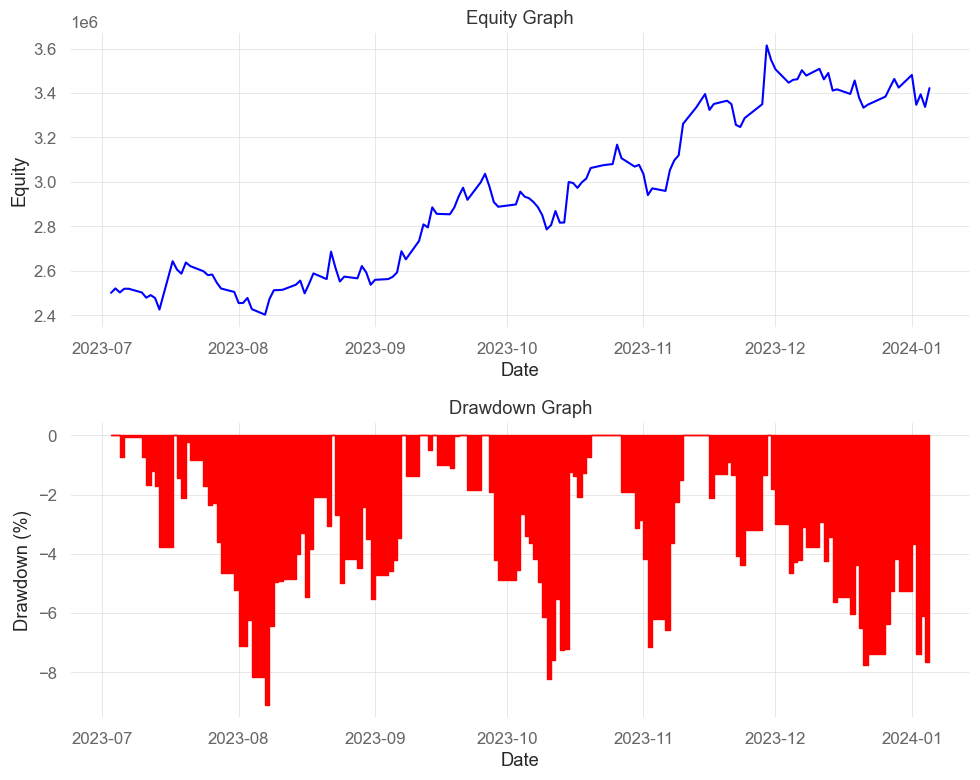

In [4]:
import matplotlib.pyplot as plt

# Account value
account_value = 2500000

# Calculate the cumulative NetPnL to simulate the equity curve
dtd_data['Cumulative NetPnL'] = dtd_data['NetPnL'].cumsum()
dtd_data['Equity'] = account_value + dtd_data['Cumulative NetPnL']

# Calculate the running maximum of the equity to date
running_max = dtd_data['Equity'].cummax()

# Calculate the drawdown in terms of amount and percentage
dtd_data['Drawdown'] = dtd_data['Equity'] - running_max
dtd_data['Drawdown Percent'] = (dtd_data['Drawdown'] / running_max) * 100

# Plotting the Equity and Drawdown graphs
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Equity Graph
axs[0].plot(dtd_data['Date'], dtd_data['Equity'], label='Equity Curve', color='blue')
axs[0].set_title('Equity Graph')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Equity')
axs[0].grid(True)

# Drawdown Graph
axs[1].fill_between(dtd_data['Date'], 0, dtd_data['Drawdown Percent'], color='red', step='post')
axs[1].set_title('Drawdown Graph')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Drawdown (%)')
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [5]:
import calendar

monthly_absolute_returns = dtd_data.groupby(['Year', 'Month_Num'])['NetPnL'].sum()

# For week-on-week basis, first let's extract the week number from the Date.
dtd_data['Week_Num'] = dtd_data['Date'].dt.isocalendar().week

# Absolute returns for each week (in Rs.)
weekly_absolute_returns = dtd_data.groupby(['Year', 'Week_Num'])['NetPnL'].sum()

# Reshaping the data to create heatmaps for both monthly and weekly absolute returns
monthly_returns_pivot = monthly_absolute_returns.unstack(level=-1)
weekly_returns_pivot = weekly_absolute_returns.unstack(level=-1)

monthly_returns_table = monthly_absolute_returns.reset_index()
weekly_returns_table = weekly_absolute_returns.reset_index()

# Renaming columns for clarity
monthly_returns_table.columns = ['Year', 'Month', 'Monthly Absolute Returns (Rs.)']
weekly_returns_table.columns = ['Year', 'Week', 'Weekly Absolute Returns (Rs.)']

# Converting Month number back to Month name for the monthly table
monthly_returns_table['Month'] = monthly_returns_table['Month'].apply(lambda x: calendar.month_name[x])

monthly_returns_table, weekly_returns_table


KeyError: 'Year'

In [23]:
# To find the maximum loss day and maximum profit day, I'll identify the rows with the minimum and maximum NetPnL values.

max_loss_day = dtd_data.loc[dtd_data['NetPnL'].idxmin()]
max_profit_day = dtd_data.loc[dtd_data['NetPnL'].idxmax()]

max_loss_day_date = max_loss_day['Date']
max_loss_day_value = max_loss_day['NetPnL']

max_profit_day_date = max_profit_day['Date']
max_profit_day_value = max_profit_day['NetPnL']

max_loss_day_date, max_loss_day_value, max_profit_day_date, max_profit_day_value


(Timestamp('2024-01-02 00:00:00'),
 -134143.32,
 Timestamp('2023-11-29 00:00:00'),
 264660.81)

In [24]:
import numpy as np

# Recovery Factor: Net Profit / Maximum Drawdown
net_profit = dtd_data['NetPnL'].sum()
max_drawdown = -dtd_data['Drawdown'].min()  # Drawdown values are negative, so taking the negative of the minimum gives the maximum drawdown
recovery_factor = net_profit / max_drawdown if max_drawdown != 0 else np.nan

# Risk-Return Ratio: Average Annual Return / Standard Deviation of Annual Returns
annual_return = dtd_data['NetPnL'].sum() / len(dtd_data['Year'].unique())
annual_std = dtd_data.groupby('Year')['NetPnL'].sum().std()
risk_return_ratio = annual_return / annual_std if annual_std != 0 else np.nan

# Average Loss
average_loss = dtd_data[dtd_data['NetPnL'] < 0]['NetPnL'].mean()

# Compound Annual Growth Rate (CAGR)
days = (dtd_data['Date'].max() - dtd_data['Date'].min()).days
cagr = ((dtd_data['Equity'].iloc[-1] / account_value) ** (365/days) - 1) * 100

# Win-Loss Ratio: Total Wins / Total Losses
wins = dtd_data[dtd_data['NetPnL'] > 0]['NetPnL'].sum()
losses = -dtd_data[dtd_data['NetPnL'] < 0]['NetPnL'].sum()  # Losses are negative, so we take the negative to make it positive
win_loss_ratio = wins / losses if losses != 0 else np.nan

# Sharpe Ratio: (Return of Investment - Risk Free Rate) / Standard Deviation of Returns
# Assuming a risk-free rate of 0 for simplicity.
daily_return = dtd_data['NetPnL'] / account_value
sharpe_ratio = daily_return.mean() / daily_return.std() if daily_return.std() != 0 else np.nan


(3.2877537192708486,
 0.7032845346518676,
 -39479.9544262295,
 85.13471270522155,
 1.3827444873642913,
 0.11853312285893279)

In [26]:
# Calculating consecutive losses, consecutive wins, gain to pain ratio, and kelly criterion.

# Consecutive losses and wins
dtd_data['Win'] = dtd_data['NetPnL'] > 0
consecutive_losses = dtd_data['Win'].astype(int).groupby(dtd_data['Win'].ne(dtd_data['Win'].shift()).cumsum()).cumcount()
consecutive_wins = dtd_data['Win'].astype(int)[::-1].groupby(dtd_data['Win'].ne(dtd_data['Win'].shift()).cumsum()).cumcount()

max_consecutive_losses = consecutive_losses.max()
max_consecutive_wins = consecutive_wins.max()

# Gain to Pain Ratio: Total Returns / Absolute Sum of All Losses
total_returns = dtd_data['NetPnL'].sum()
total_losses = -dtd_data[dtd_data['NetPnL'] < 0]['NetPnL'].sum()  # Sum of absolute losses
gain_to_pain_ratio = total_returns / total_losses if total_losses != 0 else np.nan

# Kelly Criterion: (Winning Probability * Average Win) / Average Loss - (Losing Probability * Average Loss) / Average Win
# It's a formula used to determine the optimal size of a series of bets.
winning_prob = len(dtd_data[dtd_data['NetPnL'] > 0]) / len(dtd_data)
average_win = dtd_data[dtd_data['NetPnL'] > 0]['NetPnL'].mean()
losing_prob = len(dtd_data[dtd_data['NetPnL'] < 0]) / len(dtd_data)
kelly_criterion = (winning_prob * average_win / -average_loss) - (losing_prob * -average_loss / average_win) if average_loss != 0 else np.nan

max_consecutive_losses, max_consecutive_wins, gain_to_pain_ratio, kelly_criterion


(5, 5, 0.38274448736429106, 0.2354765422702087)